# 2D FEM with quadratic triangles

## Step 1: read in the mesh

In [4]:
import numpy as np
import scipy.sparse as sparse
import scipy.linalg as la
import scipy.sparse.linalg as sla
import gmsh
mesh = gmsh.Mesh()

# mesh.read_msh('aq2.msh') # coarse
mesh.read_msh('aq3.msh') # middle
# mesh.read_msh('aq4.msh') # fine

## Only works for quadratic triangle elements
E = mesh.Elmts[9][1]
V = mesh.Verts[:,:2]

ne = E.shape[0] #
nv = V.shape[0]
X = V[:,0]      # X shape: nv x 1
Y = V[:,1]
print(np.shape(E))
print(np.shape(V))

(620, 6)
(1309, 2)


### Aside: code snippets to plot the mesh, and a random function on this mesh

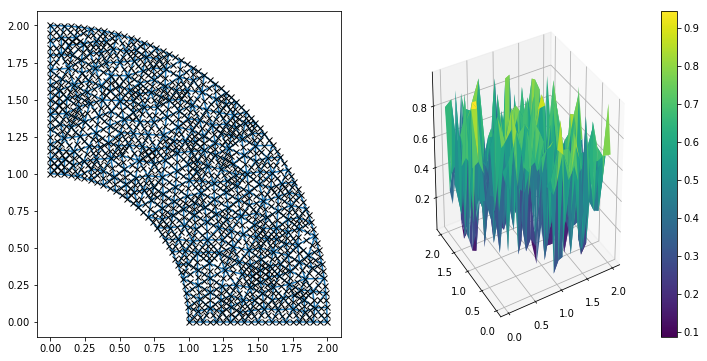

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,2,1)
ax.triplot(X,Y,E[:,:3])
ax.plot(X,Y,'kx')

ax = fig.add_subplot(1,2,2, projection='3d')
u = np.random.rand(X.size)

surf = ax.plot_trisurf(X, Y, u, triangles=E[:,:3], cmap=plt.cm.viridis)
fig.colorbar(surf)
ax.view_init(30,-120)

## Step 2: find the basis functions and its derivatives

Shape functions on a reference triangle $(0\le r\le 1, 0\le s\le 1-r)$ are

$$
\begin{aligned}
\phi_1&=(1-r-s)(1-2r-2s), &\phi_2&=-r(1-2r), &\phi_3&=-s(1-2s),\\
\phi_4&=4r(1-r-s),        &\phi_5&=4rs, &\phi_6&=4s(1-r-s).\\
\end{aligned}
$$

The following node numbering is assumed

$$
\begin{aligned}
(r,s)_1 &= (0,0), &(r,s)_2 &= (1,0), &(r,s)_3 &= (0,1),\\
(r,s)_4 &= (0.5,0), &(r,s)_5 &= (0.5,0.5), &(r,s)_6 &= (0,0.5).\\
\end{aligned}
$$

In [6]:
def diffbasis_func(r,s):
    deri_basis=np.array([[4*s+4*r-3, 4*r-1, 0,4-8*r-4*s,4*s,-4*s],
              [4*s+4*r-3, 0, 4*s-1,-4*r,4*r,4-4*r-8*s]])
    return deri_basis
def basis_func(r,s):
    basis=np.array([(1-r-s)*(1-2*r-2*s),-r*(1-2*r),-s*(1-2*s),4*r*(1-r-s),4*r*s,4*s*(1-r-s)])
    return basis

## Step 3: generate element-wise stiffness matrix and right-hand side
## Step 4: global assembly

You will need to evaluate numerical quadrature using Gaussian quadrature rules.
A file(trigauss.py) with Gauss points and weights is provided.
Consider how many quadrature points you need for your solver.

In [7]:
def trigauss(n):
    if (n == 1):
        xw=np.array([[0.33333333333333, 0.33333333333333, 1.00000000000000]])
    elif (n == 2):
        xw=np.array([[0.16666666666667, 0.16666666666667, 0.33333333333333],
                     [0.16666666666667, 0.66666666666667, 0.33333333333333],
                     [0.66666666666667, 0.16666666666667, 0.33333333333333]])
    elif (n == 3):
        xw=np.array([[0.33333333333333, 0.33333333333333, -0.56250000000000],
                     [0.20000000000000, 0.20000000000000, 0.52083333333333],
                     [0.20000000000000, 0.60000000000000, 0.52083333333333],
                     [0.60000000000000, 0.20000000000000, 0.52083333333333]])
    elif (n == 4):
        xw=np.array([[0.44594849091597, 0.44594849091597, 0.22338158967801],
                     [0.44594849091597, 0.10810301816807, 0.22338158967801],
                     [0.10810301816807, 0.44594849091597, 0.22338158967801],
                     [0.09157621350977, 0.09157621350977, 0.10995174365532],
                     [0.09157621350977, 0.81684757298046, 0.10995174365532],
                     [0.81684757298046, 0.09157621350977, 0.10995174365532]])
    elif (n == 5):
        xw=np.array([[0.33333333333333, 0.33333333333333, 0.22500000000000],
                     [0.47014206410511, 0.47014206410511, 0.13239415278851],
                     [0.47014206410511, 0.05971587178977, 0.13239415278851],
                     [0.05971587178977, 0.47014206410511, 0.13239415278851],
                     [0.10128650732346, 0.10128650732346, 0.12593918054483],
                     [0.10128650732346, 0.79742698535309, 0.12593918054483],
                     [0.79742698535309, 0.10128650732346, 0.12593918054483]])
    elif (n == 6):
        xw=np.array([[0.24928674517091, 0.24928674517091, 0.11678627572638 ],
                     [0.24928674517091, 0.50142650965818, 0.11678627572638 ],
                     [0.50142650965818, 0.24928674517091, 0.11678627572638 ],
                     [0.06308901449150, 0.06308901449150, 0.05084490637021 ],
                     [0.06308901449150, 0.87382197101700, 0.05084490637021 ],
                     [0.87382197101700, 0.06308901449150, 0.05084490637021 ],
                     [0.31035245103378, 0.63650249912140, 0.08285107561837 ],
                     [0.63650249912140, 0.05314504984482, 0.08285107561837 ],
                     [0.05314504984482, 0.31035245103378, 0.08285107561837 ],
                     [0.63650249912140, 0.31035245103378, 0.08285107561837 ],
                     [0.31035245103378, 0.05314504984482, 0.08285107561837 ],
                     [0.05314504984482, 0.63650249912140, 0.08285107561837]])
    elif (n == 7):
        xw=np.array([[0.33333333333333, 0.33333333333333, -0.14957004446768],
                     [0.26034596607904, 0.26034596607904, 0.17561525743321 ],
                     [0.26034596607904, 0.47930806784192, 0.17561525743321 ],
                     [0.47930806784192, 0.26034596607904, 0.17561525743321 ],
                     [0.06513010290222, 0.06513010290222, 0.05334723560884 ],
                     [0.06513010290222, 0.86973979419557, 0.05334723560884 ],
                     [0.86973979419557, 0.06513010290222, 0.05334723560884 ],
                     [0.31286549600487, 0.63844418856981, 0.07711376089026 ],
                     [0.63844418856981, 0.04869031542532, 0.07711376089026 ],
                     [0.04869031542532, 0.31286549600487, 0.07711376089026 ],
                     [0.63844418856981, 0.31286549600487, 0.07711376089026 ],
                     [0.31286549600487, 0.04869031542532, 0.07711376089026 ],
                     [0.04869031542532, 0.63844418856981, 0.07711376089026]])
    elif (n >= 8):
        if(n>8):
            print('trigauss: n too high, taking n=8 instead.')
        xw=np.array([[0.33333333333333, 0.33333333333333, 0.14431560767779],
                     [0.45929258829272, 0.45929258829272, 0.09509163426728],
                     [0.45929258829272, 0.08141482341455, 0.09509163426728],
                     [0.08141482341455, 0.45929258829272, 0.09509163426728],
                     [0.17056930775176, 0.17056930775176, 0.10321737053472],
                     [0.17056930775176, 0.65886138449648, 0.10321737053472],
                     [0.65886138449648, 0.17056930775176, 0.10321737053472],
                     [0.05054722831703, 0.05054722831703, 0.03245849762320],
                     [0.05054722831703, 0.89890554336594, 0.03245849762320],
                     [0.89890554336594, 0.05054722831703, 0.03245849762320],
                     [0.26311282963464, 0.72849239295540, 0.02723031417443],
                     [0.72849239295540, 0.00839477740996, 0.02723031417443],
                     [0.00839477740996, 0.26311282963464, 0.02723031417443],
                     [0.72849239295540, 0.26311282963464, 0.02723031417443],
                     [0.26311282963464, 0.00839477740996, 0.02723031417443],
                     [0.00839477740996, 0.72849239295540, 0.02723031417443]])


    qx = xw[:,:2]
    qw = xw[:,2]/2
    return qx, qw

In [8]:
qx,qw=trigauss(4)

#created space for the data, row, and column indices of the matrix (AA, IA, JA) and of the right-hand side (bb, ib,jb)
AA = np.zeros((ne, 36))
IA = np.zeros((ne, 36))
JA = np.zeros((ne, 36))
bb = np.zeros((ne, 6))
ib = np.zeros((ne, 6))
jb = np.zeros((ne, 6))


for ei in range(0, ne):
    # Step 1
    K = E[ei, :]
    x0, y0 = X[K[0]], Y[K[0]]
    x1, y1 = X[K[1]], Y[K[1]]
    x2, y2 = X[K[2]], Y[K[2]]


    # Step 2
    J = np.array([[x1 - x0, x2 - x0],
                  [y1 - y0, y2 - y0]])
    invJ = la.inv(J.T)
    detJ = la.det(J)

    # Step 3
    dbasis=[]
    basis=[]
    for i in range(np.shape(qx)[0]):
        dbasis.append(diffbasis_func(qx[i,0],qx[i,1]))
        basis.append(basis_func(qx[i,0],qx[i,1]))

    # Step 4
    dphi=[]
    for i in range(np.shape(qx)[0]):
        dphi.append(invJ.dot(dbasis[i]))

    # Step 5
    Aelem=np.zeros((6,6))
    for i in range(np.shape(qx)[0]):
        Aelem=Aelem+detJ*(qw[i]*(dphi[i].T).dot(dphi[i]))

    # Step 6
    belem=np.zeros((6,))
    for i in range(np.shape(qx)[0]):
        belem=belem+detJ*np.ones((6,))*qw[i]* basis[i]
    
    # Step 7, Assembly
    AA[ei, :] = Aelem.ravel()
    IA[ei, :] = [K[0], K[0], K[0],K[0], K[0], K[0],K[1], K[1], K[1], K[1], K[1], K[1], 
                 K[2], K[2], K[2],K[2], K[2], K[2],K[3], K[3], K[3],K[3], K[3], K[3],
                 K[4],K[4],K[4],K[4],K[4],K[4],K[5],K[5],K[5],K[5],K[5],K[5]]
    
    JA[ei, :] = [K[0], K[1], K[2],K[3], K[4], K[5], 
                 K[0], K[1], K[2],K[3], K[4], K[5], 
                 K[0], K[1], K[2],K[3], K[4], K[5],
                 K[0], K[1], K[2],K[3], K[4], K[5],
                 K[0], K[1], K[2],K[3], K[4], K[5],
                 K[0], K[1], K[2],K[3], K[4], K[5]]
    bb[ei, :] = belem.ravel()
    ib[ei, :] = [K[0], K[1], K[2],K[3], K[4], K[5]]
    jb[ei, :] = 0

#convert back to COO for easier manipulation.
A = sparse.coo_matrix((AA.ravel(), (IA.ravel(), JA.ravel())))
A = A.tocsr()
A = A.tocoo()
b = sparse.coo_matrix((bb.ravel(), (ib.ravel(), jb.ravel())))
b = b.tocsr()
b = np.array(b.todense()).ravel()

## Step 5: apply boundary conditions and solve

In [9]:
#Add boundary condition:
tol = 1e-12
Dflag = np.logical_or.reduce((abs(X*X+Y*Y-1.0) < tol,
                              abs(Y*Y+X*X-4.0) < tol))
ID = np.where(Dflag)[0]
for k in range(0, len(A.data)):
    i = A.row[k]
    j = A.col[k]
    if Dflag[i] or Dflag[j]:
        if i == j:
            A.data[k] = 1.0
        else:
            A.data[k] = 0.0
b[ID] = 0.0

A = A.tocsr()
u = sla.spsolve(A, b)

## Step 6: compute error

In [10]:
#Infinity error:
def ue(x,y):
    r = np.sqrt(np.power(x,2)+np.power(y,2))
    return (-1/4*r*r+3/(4*np.log(2))*np.log(r)+1/4)

uex = ue(X,Y)

er = la.norm(uex-u,np.inf)/la.norm(uex,np.inf)
print(er)

0.00358599351521


## Step 7: plot

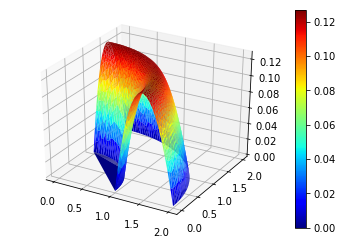

In [11]:
fig = plt.figure()
ax = plt.gca(projection='3d')
surf = ax.plot_trisurf(X, Y, u, triangles=E, cmap=plt.cm.jet, linewidth=0.2)
fig.colorbar(surf)
plt.show() 

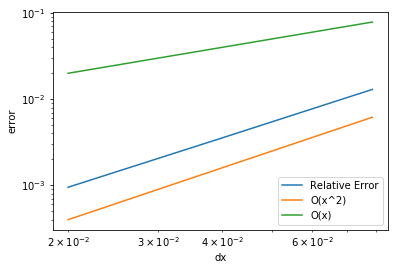

In [12]:
#error
er_list=[0.012991245562,0.00358599351521,0.000950168553311]
dx=np.array([0.0785674201318,0.0401609664451,0.0199800299501])
plt.figure()
plt.loglog(dx,er_list, label='Relative Error')
plt.loglog(dx,dx**2,label='O(x^2)')
plt.loglog(dx,dx,label='O(x)')
plt.xlabel('dx')
plt.ylabel('error')    
plt.legend(frameon=True)